In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from IPython.display import clear_output
import sys


In [ ]:
class NeuralNetwork:
    def __init__(self, hidden_layers_dimensions, outputs, inputs):
        self.input_layer_dimension = inputs.shape[0]
        self.hidden_layers_dimensions = hidden_layers_dimensions
        self.output_layer_dimension = outputs.shape[0]
        self.input_layer = tf.convert_to_tensor(inputs, dtype=tf.float32)
        self.output = tf.convert_to_tensor(outputs, dtype=tf.float32)

        self.weights = []
        self.biases = []

        # Input to first hidden layer
        self.weights.append(tf.Variable(tf.random.normal([self.hidden_layers_dimensions[0], self.input_layer_dimension], stddev=0.1, dtype=tf.float32)))
        self.biases.append(tf.Variable(tf.zeros([self.hidden_layers_dimensions[0], 1], dtype=tf.float32)))

        # Hidden layers
        for i in range(1, len(self.hidden_layers_dimensions)):
            self.weights.append(tf.Variable(tf.random.normal([self.hidden_layers_dimensions[i], self.hidden_layers_dimensions[i - 1]], stddev=tf.sqrt(1.0 / self.hidden_layers_dimensions[i - 1]), dtype=tf.float32)))
            self.biases.append(tf.Variable(tf.zeros([self.hidden_layers_dimensions[i], 1], dtype=tf.float32)))

        self.weights.append(tf.Variable(tf.random.normal([self.output_layer_dimension, self.hidden_layers_dimensions[-1]], stddev=tf.sqrt(1.0 / self.hidden_layers_dimensions[-1]), dtype=tf.float32)))
        self.biases.append(tf.Variable(tf.zeros([self.output_layer_dimension, 1], dtype=tf.float32)))

    def forward_pass(self):
        self.hidden_layers_outputs = []
        self.hidden_layers_outputs.append(tf.nn.relu(tf.add(tf.matmul(self.weights[0], self.input_layer), self.biases[0])))
        for i in range(1, len(self.hidden_layers_dimensions)):
            self.hidden_layers_outputs.append(tf.nn.relu(tf.add(tf.matmul(self.weights[i], self.hidden_layers_outputs[i - 1]), self.biases[i])))
        self.output_layer_output = tf.add(tf.matmul(self.weights[-1], self.hidden_layers_outputs[-1]), self.biases[-1])
        return self.output_layer_output
    
    def backward_pass(self):
        self.output_layer_error = tf.subtract(self.output_layer_output, self.output)
        self.output_layer_delta = tf.multiply(self.output_layer_error, tf.nn.relu(self.output_layer_output))
        self.hidden_layers_errors = []
        self.hidden_layers_deltas = []
        for i in range(len(self.hidden_layers_dimensions) - 1, -1, -1):
            self.hidden_layers_errors.append(tf.matmul(tf.transpose(self.weights[i + 1]), self.output_layer_delta))
            self.hidden_layers_deltas.append(tf.multiply(self.hidden_layers_errors[len(self.hidden_layers_errors) - 1], tf.nn.relu(self.hidden_layers_outputs[i])))
        self.hidden_layers_errors.reverse()
        self.hidden_layers_deltas.reverse()
        return self.hidden_layers_deltas
    
    def triann(self, epochs, learning_rate):
        for epoch in range(epochs):
            self.forward_pass()
            self.backward_pass()
            for i in range(len(self.hidden_layers_dimensions)):
                self.weights[i] = tf.add(self.weights[i], tf.multiply(learning_rate, tf.matmul(self.hidden_layers_deltas[i], tf.transpose(self.hidden_layers_outputs[i]))))
                self.biases[i] = tf.add(self.biases[i], tf.multiply(learning_rate, tf.reduce_sum(self.hidden_layers_deltas[i], axis=1, keepdims=True)))
            self.weights[-1] = tf.add(self.weights[-1], tf.multiply(learning_rate, tf.matmul(self.output_layer_delta, tf.transpose(self.hidden_layers_outputs[-1])))
            self.biases[-1] = tf.add(self.biases[-1], tf.multiply(learning_rate, tf.reduce_
        

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "4"  # Adjust based on CPU cores
os.environ["TF_NUM_INTEROP_THREADS"] = "4"

import tensorflow as tf
tf.keras.mixed_precision.set_global_policy('mixed_float16')
class NeuralNetwork:
    def __init__(self, input_size, output_size, hidden_layers, network_type="classifier"):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.network_type = network_type

        tf.config.threading.set_intra_op_parallelism_threads(0)
        tf.config.threading.set_inter_op_parallelism_threads(0)
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        
        self.weights, self.biases = self.initialize_weights()

    def initialize_weights(self):
        weights = {}
        biases = {}
        prev_layer_size = self.input_size
        
        for i, layer_size in enumerate(self.hidden_layers):
            weights[f"W{i+1}"] = tf.Variable(tf.random.normal([prev_layer_size, layer_size], stddev=0.1, dtype=tf.float16))
            biases[f"b{i+1}"] = tf.Variable(tf.zeros([layer_size], dtype=tf.float16))
            prev_layer_size = layer_size

        weights["W_out"] = tf.Variable(tf.random.normal([prev_layer_size, self.output_size], stddev=0.1, dtype=tf.float16))
        biases["b_out"] = tf.Variable(tf.zeros([self.output_size], dtype=tf.float16))

        return weights, biases

    @tf.function(jit_compile=True)
    def build_model(self, inputs):
        layer = inputs
        for i in range(len(self.hidden_layers)):
            layer = tf.nn.relu(tf.add(tf.matmul(layer, self.weights[f"W{i+1}"],), self.biases[f"b{i+1}"]))
        outputs = tf.add(tf.matmul(layer, self.weights["W_out"]), self.biases["b_out"])
        return tf.nn.softmax(outputs) if self.network_type == "classifier" else outputs

    def train(self, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001, verbose=True):
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        for epoch in range(epochs):
            total_loss = 0
            for batch_x, batch_y in dataset:
                with tf.GradientTape() as tape:
                    outputs = self.build_model(batch_x)
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=batch_y)) if self.network_type == "classifier" else tf.reduce_mean(tf.square(outputs - batch_y))
                gradients = tape.gradient(loss, list(self.weights.values()) + list(self.biases.values()))
                optimizer.apply_gradients(zip(gradients, list(self.weights.values()) + list(self.biases.values())))
                total_loss += loss.numpy()
            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(X_train):.6f}")
        print("Training Complete!")
    
    def predict(self, X_test):
        return self.build_model(X_test).numpy()


In [29]:
brain_one = NeuralNetwork(2 , 1 , [10] , network_type = 'classification')

In [30]:
x_train = [[1,2],[2,3],[3,4],[4,5]]
y_train = [[3],[5],[7],[9]]

In [31]:
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

brain_one.train(x_train_tensor, y_train_tensor, epochs=1000, verbose=1)

Epoch 1000/1000, Loss: 0.024380
Training Complete!


In [32]:
x_test = [2,4]
x_test_tensor = tf.convert_to_tensor(x_test , dtype=tf.float32)


In [33]:
# Reshape x_test_tensor to match the input dimensions of the network
x_test_tensor_reshaped = tf.reshape(x_test_tensor, (1, 2))

# Predict using the reshaped tensor
brain_one.predict(x_test_tensor_reshaped)

array([[6.13254]], dtype=float32)

In [46]:
dataframe = pd.read_csv("/Users/sriramkurnella/AI/Machine Learning A-Z (Codes and Datasets)/Part 2 - Regression/Section 6 - Polynomial Regression/Python/Position_Salaries.csv")
X = dataframe.iloc[:, 1:2].values
y = dataframe.iloc[:, 2].values

x_train = tf.convert_to_tensor(X , dtype=tf.float32)
y_train = tf.convert_to_tensor(y , dtype=tf.float32)


In [47]:
dataframe.head()

,Position,Level,Salary
0,Business Analyst,1,45000
1,Junior Consultant,2,50000
2,Senior Consultant,3,60000
3,Manager,4,80000
4,Country Manager,5,110000


In [54]:
brain_two = NeuralNetwork(1 , 1 , [10 , 10] , network_type = 'regression')
brain_two.train(x_train , y_train , epochs = 1000 , learning_rate = 0.1)

Epoch 1000/1000, Loss: 8066224947.200000
Training Complete!


In [55]:
x_test = [2]
x_test_tensor = tf.convert_to_tensor(x_test , dtype=tf.float32)

In [56]:
brain_two.predict(tf.reshape(x_test_tensor, (1, 1)))

array([[249499.64]], dtype=float32)

In [107]:
from tensorflow.keras.datasets import mnist

# Load MNIST Dataset
(train_inputs, train_outputs), (test_inputs, test_outputs) = mnist.load_data()

# Flatten images from (28,28) to (784,) and normalize
train_inputs = train_inputs.reshape(60000, 784).T / 255.0  # Shape: (784, 60000)
test_inputs = test_inputs.reshape(10000, 784).T / 255.0    # Shape: (784, 10000)

# Convert labels to one-hot encoding (10 classes)
train_outputs = np.eye(10)[train_outputs].T  # Shape: (10, 60000)
test_outputs = np.eye(10)[test_outputs].T    # Shape: (10, 10000)

# Convert to TensorFlow tensors
train_inputs = tf.convert_to_tensor(train_inputs, dtype=tf.float32)
train_outputs = tf.convert_to_tensor(train_outputs, dtype=tf.float32)

In [108]:

# Create the neural network
brain_three = NeuralNetwork(784, 10, [64, 16], network_type='classification')

RuntimeError: Intra op parallelism cannot be modified after initialization.

In [75]:

train_inputs_transposed = tf.transpose(train_inputs)
train_outputs_transposed = tf.transpose(train_outputs)

brain_three.train(train_inputs_transposed, train_outputs_transposed, epochs=1000, verbose=True, learning_rate=0.01)

Epoch 20/1000, Loss: 0.000251


KeyboardInterrupt: 

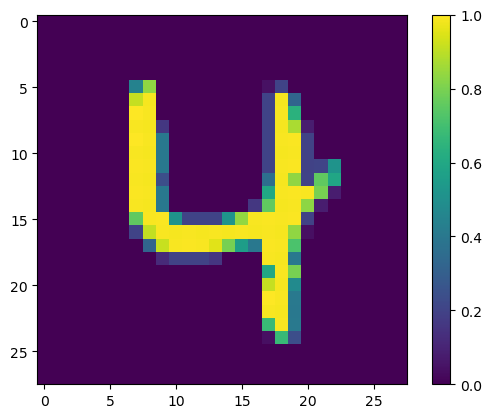

In [87]:
number = 49
plt.figure()
plt.imshow(test_inputs[:, number].reshape(28, 28))
plt.colorbar()
plt.grid(False)
plt.show()

In [88]:
# Ensure the test_inputs tensor is of type float32
test_inputs_float32 = tf.convert_to_tensor(test_inputs, dtype=tf.float32)

# Reshape the selected test input to match the expected input dimensions of the model
test_input_reshaped = tf.reshape(test_inputs_float32[:, number], (1, -1))

# Predict using the reshaped tensor
brain_three.predict(test_input_reshaped)

array([[ 9.9100545e-03, -1.3100803e-03, -3.4118593e-03, -9.3183443e-03,
         1.0609727e+00, -2.6644856e-02,  3.3519082e-02,  1.1526361e-02,
        -4.8178434e-04, -6.6833124e-03]], dtype=float32)